In [5]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from generator import RoadNetwork, Trajectory
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
network = RoadNetwork()
network.load("../osm_data/porto")
# trajectory = Trajectory("../datasets/trajectories/Porto/road_segment_map_final.csv", nrows=10000000).generate_TTE_datatset()

traj_features = pd.read_csv("../datasets/trajectories/Porto/speed_features_unnormalized.csv")
traj_features.set_index(["u", "v", "key"], inplace=True)
# traj_features["util"] = (traj_features["util"] - traj_features["util"].min()) / (traj_features["util"].max() - traj_features["util"].min())  # min max normalization
# traj_features["avg_speed"] = (traj_features["avg_speed"] - traj_features["avg_speed"].min()) / (traj_features["avg_speed"].max() - traj_features["avg_speed"].min())  # min max normalization
traj_features.fillna(0, inplace=True)

# data = network.generate_road_segment_pyg_dataset(drop_labels=["highway_enc"])
df = network.generate_road_segment_pyg_dataset(include_coords=True, traj_data=traj_features, return_df=True, one_hot_enc=False)

(11331, 12)


/tmp/ipykernel_2442/1339262203.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap="viridis",


<AxesSubplot:>

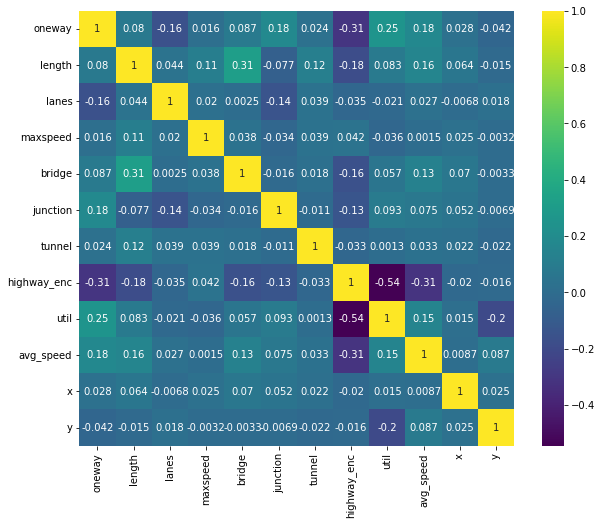

In [4]:
print(df.shape)
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap="viridis",
            square=True, ax=ax, annot=True)

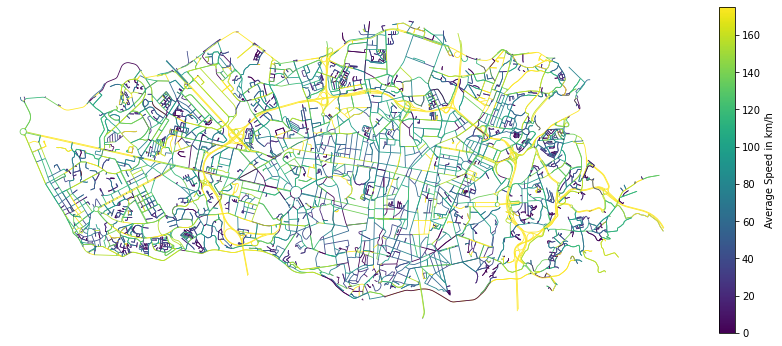

In [62]:
"""
Plot utilization and mean speed edge heatmap to show that there is correlation 
"""
import matplotlib.cm as cm

def get_colors(n, cmap='viridis', start=0., stop=1., alpha=1.):

    colors = [cm.get_cmap(cmap)(x) for x in np.linspace(start, stop, n)]
    colors = [(r, g, b, alpha) for r, g, b, _ in colors]
    return colors


def get_edge_colors_by_attr(G, lG, df, attr, num_bins=None, cmap='viridis', start=0, stop=1, na_color='none', cat_feature=False):

    if num_bins is None:
        num_bins = len(G.nodes())
    bin_labels = range(num_bins)
    nodes = list(lG.nodes)
    attr_values = pd.Series([df.iloc[nodes.index(id)][attr] for id in G.edges])
    # print(attr_values)
    if not cat_feature:
        cats = pd.qcut(x=attr_values, q=num_bins, labels=bin_labels)  # Puts the values in bins
    else:
        cats = attr_values
    # print(cats)
    colors = get_colors(num_bins, cmap, start, stop)  #List of colors of each bin
    node_colors = [colors[int(cat)] if pd.notnull(cat) else na_color for cat in cats]

    return node_colors

nc_util = get_edge_colors_by_attr(network.G, network.line_graph, df, attr='util', num_bins=10)
nc_speed = get_edge_colors_by_attr(network.G, network.line_graph, df, attr='avg_speed', num_bins=10)


cmap = plt.cm.get_cmap('viridis')
norm_util=plt.Normalize(vmin=df["util"].min(), vmax=df["util"].max())
norm_speed =plt.Normalize(vmin=df["avg_speed"].min(), vmax=df["avg_speed"].max())

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
# ox.plot_graph(network.G, edge_color=nc_util, node_size=0, edge_linewidth=0.8, edge_alpha=1, bgcolor = 'white', show=False, ax=ax)
ox.plot_graph(network.G, edge_color=nc_speed, node_size=0, edge_linewidth=0.8, bgcolor = 'white', show=False, ax=ax)
# cb = fig.colorbar(cm.ScalarMappable(norm=norm_util, cmap=cmap), ax=ax, orientation='vertical')
# cb.set_label('Utilization', fontsize = 10)
cb = fig.colorbar(cm.ScalarMappable(norm=norm_speed, cmap=cmap), ax=ax, orientation='vertical')
cb.set_label('Average Speed in km/h', fontsize = 10)

fig.savefig("../data/images/porto_speed.png")

In [66]:
""" 
Plot road types
"""
print(df["highway_enc"].unique())
nc_road = get_edge_colors_by_attr(network.G, network.line_graph, df, attr='highway_enc', num_bins=13)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


ValueError: Bin edges must be unique: array([ 0.,  2.,  2.,  7.,  7., 10., 10., 10., 10., 10., 10., 10., 12.,
       12., 12.]).
You can drop duplicate edges by setting the 'duplicates' kwarg